In [1]:
import sys
import os
import json
import numpy as np
from os.path import join as pjoin
from tqdm import tqdm
import time
import datetime
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


experiment_path = 'mel2CFfeats/mel2musicnn_config_file.json'

In [2]:
with open(experiment_path, 'r') as f:
    _opt = json.load(f)
torch.manual_seed(_opt['seed']);

In [3]:
class MPD_listenBals_dataset(Dataset):
    """ The intersection of MelonPlaylistDataset and Kakao's CF model listen-bals-31d features. """
    def __init__(self, mpd_path, chunk_size, subset_ratio):
        self.embeddings = np.load(pjoin(_opt['embeddings_path'], 'embeddings_msd-musicnn-1.pb.npy'))
        self.chunk_size = chunk_size
        self.mpd_path = mpd_path
        self.subset_ratio = subset_ratio
            
    def __len__(self):
        return int(len(self.embeddings) * self.subset_ratio)
    
    def __getitem__(self, idx):
        embedding = torch.from_numpy(self.embeddings[idx, :])
        folder = str(idx // 1000)
        filename = str(idx) + '.npy'
        
        melspec = torch.from_numpy(np.load(pjoin(pjoin(self.mpd_path, folder), filename)))
        
        #If file is smaller than cunksize, we padd
        if melspec.shape[1] < self.chunk_size:
            #padd
            zerostoadd = self.chunk_size - melspec.shape[1]
            melspec = torch.cat((melspec, torch.zeros(melspec.shape[0], zerostoadd)), dim=1)
        if melspec.shape[1] < self.chunk_size:
            print('ERROR WHILE PADDING')
        
        #Once loaded, we randomly pick a chunk of chunk_size
        header = torch.randint(low=0, high=melspec.shape[1] - self.chunk_size + 1, size=(1,))
        melspec = melspec[:, header : header + self.chunk_size]
        return melspec, embedding

version=os.listdir(pjoin(_opt['res_dir'], _opt['CFmodel']))    
version.sort(reverse=True) #sort by date/dirname
version = version[0] #pick only the latest version

dataset = MPD_listenBals_dataset(_opt['mpd_path'],             
                                _opt['chunk_size'],
                                _opt['subset_ratio'])

In [4]:
train_len = int(len(dataset) * _opt['split_ratio'])
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, len(dataset)-train_len] ,
                                                           generator=torch.Generator().manual_seed(_opt['seed']))

stats_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=_opt['num_workers'], drop_last=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=_opt['batch_size'], shuffle=True, num_workers=_opt['num_workers'], drop_last=True)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=_opt['batch_size'], shuffle=False, num_workers=_opt['num_workers'], drop_last=True)

In [5]:
for melspec, embedding in stats_loader:
    statistics = {}
    statistics['mean_melspecs'] = torch.mean(torch.mean(melspec, dim=2), dim=0)
    statistics['std_melspecs'] = torch.std(torch.std(melspec, dim=2), dim=0)
    statistics['mean_embedding'] = torch.mean(embedding, dim=0)
    statistics['std_embedding'] = torch.std(embedding, dim=0)
    break

In [6]:
class MLP(nn.Module):
    def __init__(self, statistics, _opt):
        super(MLP, self).__init__()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        # Pons front-end
        self.embedding_size = _opt['embedding_size']
        self.lin1 = nn.Linear(_opt['melbands'] * _opt['chunk_size'],  int(_opt['melbands'] * _opt['chunk_size'] / 4))
        self.lin2 = nn.Linear(int(_opt['melbands'] * _opt['chunk_size'] / 4), _opt['embedding_size'])
    def forward(self, x):
        batch_size, bands, frames = x.shape
        #standardize (normalize to zero mean and unit variance)
        
        if torch.cuda.is_available():
            mean_melspecs = statistics['mean_melspecs'].cuda().expand(batch_size, frames, bands).permute(0,2,1)
            std_melspecs = statistics['std_melspecs'].cuda().expand(batch_size, frames, bands).permute(0,2,1)
        else:
            mean_melspecs = statistics['mean_melspecs'].expand(batch_size, frames, bands).permute(0,2,1)
            std_melspecs = statistics['std_melspecs'].expand(batch_size, frames, bands).permute(0,2,1)            
        x = (x - mean_melspecs) / std_melspecs
        
        
        
        
        x = x.view(batch_size, -1)
        x = self.relu(self.lin1(x))
        x = self.tanh(self.lin2(x))
        #De-standardize
        
        
        
        
        if torch.cuda.is_available():        
            mean_CFfeatures = statistics['mean_embedding'].cuda().expand(batch_size, self.embedding_size)  
            std_CFfeatures = statistics['std_embedding'].cuda().expand(batch_size, self.embedding_size)   
        else:
            mean_CFfeatures = statistics['mean_embedding'].expand(batch_size, self.embedding_size)  
            std_CFfeatures = statistics['std_embedding'].expand(batch_size, self.embedding_size)             
        x = ( x * std_CFfeatures ) + mean_CFfeatures   
        
        return x
    
model = MLP(statistics, _opt)
if torch.cuda.is_available():
    model = model.cuda()

In [7]:
optimizer = optim.SGD(model.parameters(), lr = _opt['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=_opt['lr_decay_gamma'],
    patience=_opt['lr_decay_patience'],
    cooldown=10
)

mse = nn.MSELoss()

In [8]:
train_loss = []
loss = 0.0
for epoch in tqdm(range(_opt['num_epochs'])):
    model.train()  
    running_loss = 0.0
    step = 0
    for melspec, CFfeature in train_loader:
        if torch.cuda.is_available():
            melspec = melspec.cuda()
            CFfeature = CFfeature.cuda()
        optimizer.zero_grad()
        output = model(melspec)
        loss = torch.sqrt(mse(output, CFfeature))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        step += 1  
    running_loss /= step
    train_loss.append(running_loss)

100%|██████████| 500/500 [1:18:10<00:00,  9.38s/it]


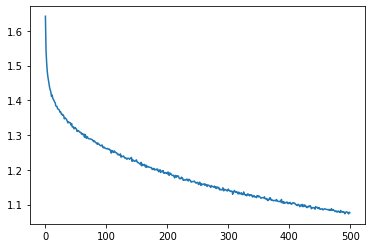

In [9]:
import matplotlib.pyplot as plt
plt.plot(train_loss)

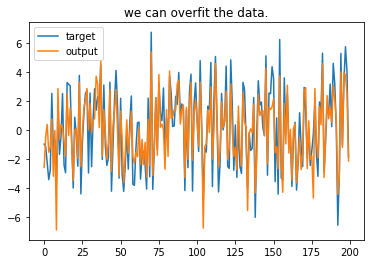

In [14]:
plt.plot(CFfeature.detach().cpu().numpy()[11])
plt.plot(output.detach().cpu().numpy()[11])

plt.legend(['target', 'output'])
plt.title('we can overfit the data.');

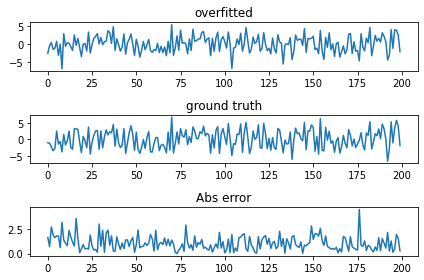

In [15]:
plt.subplot(3,1,1)
plt.plot(output.detach().cpu().numpy()[11])
plt.title('overfitted')
plt.subplot(3,1,2)
plt.plot(CFfeature.detach().cpu().numpy()[11])
plt.title('ground truth')
plt.tight_layout()
plt.subplot(3,1,3)
plt.plot(np.abs(CFfeature.detach().cpu().numpy()[11]-output.detach().cpu().numpy()[11]))
plt.title('ground truth')
plt.title('Abs error')
plt.tight_layout()


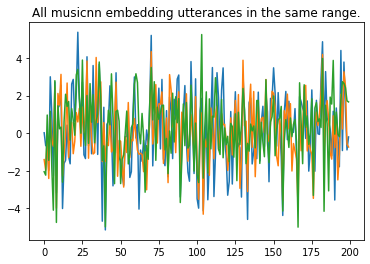

In [16]:
plt.plot(CFfeature.detach().cpu().numpy()[5])
plt.plot(CFfeature.detach().cpu().numpy()[7])
plt.plot(CFfeature.detach().cpu().numpy()[8])
plt.title('All musicnn embedding utterances in the same range.');